In [2]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

import laspated as spated

# Limit borders

In [3]:
# initial map used as max borders
max_borders = gpd.read_file('../Data/rj/')
print(type(max_borders))
max_borders

<class 'geopandas.geodataframe.GeoDataFrame'>


,OBJECTID_1,OBJECTID,MUN,SHAPE_LENG,SHAPESTAre,SHAPESTLen,geometry
0,2,NaN,NaN,NaN,1.204148e+09,375647.256369,"MULTIPOLYGON (((682113.651 7469305.612, 682113..."


<AxesSubplot:>

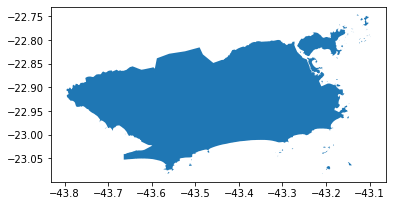

In [4]:
app = spated.DataAggregator(crs='epsg:4326') # epsg:29193
app.add_max_borders(max_borders)

app.max_borders.plot()

# Events data

In [5]:
# events data
events = pd.read_csv(r'../Data/emergency_calls_rio_de_janeiro.csv', encoding = "ISO-8859-1", sep=",")
print(type(events))
events.head(10)

<class 'pandas.core.frame.DataFrame'>


,index,prioridade,lat,long,data,hora,data_hora
0,0,3,-22.869398,-43.333665,1/1/16,2:09:13,1/1/16 2:09:13
1,1,0,-22.876186,-43.675890,1/1/16,2:13:05,1/1/16 2:13:05
2,3,1,-22.906627,-43.293335,1/1/16,2:17:06,1/1/16 2:17:06
3,6,0,-23.012424,-43.541721,1/1/16,2:28:08,1/1/16 2:28:08
4,11,2,-23.010306,-43.359431,1/1/16,2:44:53,1/1/16 2:44:53
5,12,3,-22.930439,-43.233050,1/1/16,2:45:45,1/1/16 2:45:45
6,15,0,-22.851838,-43.357152,1/1/16,2:51:25,1/1/16 2:51:25
7,18,3,-23.002122,-43.634019,1/1/16,2:56:45,1/1/16 2:56:45
8,19,2,-22.994583,-43.253164,1/1/16,2:57:20,1/1/16 2:57:20
9,20,0,-22.824990,-43.392745,1/1/16,3:00:47,1/1/16 3:00:47


In [6]:
app.add_events_data(events.sample(1000), datetime_col='data', lat_col='lat', lon_col="long", feature_cols=['prioridade'],
        datetime_format="%m/%d/%y")

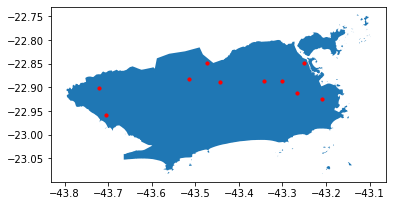

In [7]:
fig, ax = plt.subplots()
app.max_borders.plot(ax=ax)
app.events_data.sample(10).plot(markersize=10, color='red', ax=ax)
plt.show()

## We can also compute max borders based on events data!

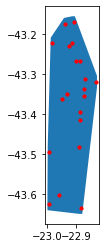

In [30]:
app2 = spated.DataAggregator(crs='epsg:4326')
# first, add events
app2.add_events_data(events.sample(20), datetime_col='data_hora', lat_col='long', lon_col="lat", feature_cols=['prioridade'],
        datetime_format="%m/%d/%y %H:%M:%S")
# then, compute borders with desired method
app2.add_max_borders(method="convex")

fig, ax = plt.subplots()
app2.max_borders.plot(ax=ax)
app2.events_data.plot(markersize=10, color='red', ax=ax)
plt.show()

# Time discretization

## Basic Seasonality

In [8]:
# 7 days in a week
app.add_time_discretization('D', 1, 7, column_name="dow")

# 48 30-minute slots in a day
app.add_time_discretization('m', 30, 60*24)

## Variable Window Time Discretization

In [9]:
app.add_time_discretization('M', [3,4,2,1,2], 12)

## Custom Time Discretization

In [10]:
time_disc_df = pd.DataFrame([
    ["2016-01-01", "2016-01-01", 1, "yearly"],
    ["2016-02-06", "2016-02-11", 2, None],
    ["2017-02-24", "2017-03-06", 2, None],
], columns=["start", "end", "t", "repetition"])

time_disc_df

,start,end,t,repetition
0,2016-01-01,2016-01-01,1,yearly
1,2016-02-06,2016-02-11,2,None
2,2017-02-24,2017-03-06,2,None


In [11]:
app.add_time_discretization(time_disc_df)

All time discretizations are represented as columns in the events dataset.

In [12]:
app.events_data.head(60)

,prioridade,geometry,ts,dow,tdiscr_1,tdiscr_2,tdiscr_3
821,1,POINT (-43.36279 -22.92826),2016-01-02,0,0,0,0
1114,1,POINT (-43.18186 -22.94465),2016-01-03,1,0,0,0
1369,3,POINT (-43.37302 -22.93233),2016-01-04,2,0,0,0
1767,3,POINT (-43.60705 -22.88656),2016-01-05,3,0,0,0
2040,1,POINT (-43.21773 -22.91843),2016-01-05,3,0,0,0
2319,3,POINT (-43.38333 -22.93228),2016-01-06,4,0,0,0
2226,2,POINT (-43.30924 -22.87718),2016-01-06,4,0,0,0
2686,1,POINT (-43.46991 -22.87914),2016-01-07,5,0,0,0
2627,1,POINT (-43.29656 -22.87742),2016-01-07,5,0,0,0
2891,0,POINT (-43.19443 -22.95133),2016-01-08,6,0,0,0


# Geographical discretization

## Rectangular

In [13]:
app.add_geo_discretization(
    discr_type='R',
    rect_discr_param_x=10,
    rect_discr_param_y=10
)
app.geo_discretization.head()

,id,neighbors,geometry,center_lat,center_lon
0,0,"[1, 6, 7]","POLYGON ((-43.65577 -23.04922, -43.65577 -23.0...",-4.854787e+06,-2.563147e+06
1,1,"[2, 0, 7, 8, 6]","POLYGON ((-43.65577 -23.04922, -43.58591 -23.0...",-4.850095e+06,-2.563099e+06
2,2,"[3, 1, 8, 9, 7]","MULTIPOLYGON (((-43.58591 -23.04922, -43.52824...",-4.843597e+06,-2.564048e+06
3,3,"[2, 9, 10, 8]","MULTIPOLYGON (((-43.50821 -23.05262, -43.50817...",-4.838224e+06,-2.564492e+06
4,4,"[5, 13, 12]","MULTIPOLYGON (((-43.19084 -23.07200, -43.19109...",-4.803046e+06,-2.565305e+06


In [14]:
app.geo_discretization["center"] = app.geo_discretization.geometry.to_crs("epsg:29193").centroid.to_crs(app.geo_discretization.crs)
app.geo_discretization["coords"] = app.geo_discretization["center"].apply(lambda x: x.representative_point().coords[:][0])
app.geo_discretization.head(20)

,id,neighbors,geometry,center_lat,center_lon,center,coords
0,0,"[1, 6, 7]","POLYGON ((-43.65577 -23.04922, -43.65577 -23.0...",-4.854787e+06,-2.563147e+06,POINT (-43.66010 -23.05091),"(-43.660099956967, -23.050912887375226)"
1,1,"[2, 0, 7, 8, 6]","POLYGON ((-43.65577 -23.04922, -43.58591 -23.0...",-4.850095e+06,-2.563099e+06,POINT (-43.61790 -23.05048),"(-43.61789892956769, -23.050480776124225)"
2,2,"[3, 1, 8, 9, 7]","MULTIPOLYGON (((-43.58591 -23.04922, -43.52824...",-4.843597e+06,-2.564048e+06,POINT (-43.55947 -23.05901),"(-43.55946651025199, -23.059009805814437)"
3,3,"[2, 9, 10, 8]","MULTIPOLYGON (((-43.50821 -23.05262, -43.50817...",-4.838224e+06,-2.564492e+06,POINT (-43.51115 -23.06300),"(-43.511148159936326, -23.06300466864772)"
4,4,"[5, 13, 12]","MULTIPOLYGON (((-43.19084 -23.07200, -43.19109...",-4.803046e+06,-2.565305e+06,POINT (-43.19478 -23.07031),"(-43.194783450074226, -23.070313751112195)"
5,5,"[4, 13]","POLYGON ((-43.14139 -23.06465, -43.14123 -23.0...",-4.797548e+06,-2.564424e+06,POINT (-43.14534 -23.06239),"(-43.145341452076124, -23.06239043891591)"
6,6,"[7, 14, 0, 15, 1]","POLYGON ((-43.65577 -23.04922, -43.66418 -23.0...",-4.854753e+06,-2.562464e+06,POINT (-43.65980 -23.04477),"(-43.659798052290554, -23.044771023097177)"
7,7,"[8, 6, 15, 1, 16, 2, 14, 0]","POLYGON ((-43.58591 -23.01553, -43.58591 -23.0...",-4.849576e+06,-2.561546e+06,POINT (-43.61323 -23.03651),"(-43.613234224678436, -23.036511011625542)"
8,8,"[9, 7, 16, 2, 17, 3, 15, 1]","POLYGON ((-43.58591 -23.04922, -43.58591 -23.0...",-4.842665e+06,-2.561080e+06,POINT (-43.55108 -23.03232),"(-43.551082475236505, -23.032320007123204)"
9,9,"[10, 8, 17, 3, 18, 16, 2]","POLYGON ((-43.51605 -23.01553, -43.44620 -23.0...",-4.835714e+06,-2.560408e+06,POINT (-43.48857 -23.02628),"(-43.48857158477771, -23.026280478885024)"


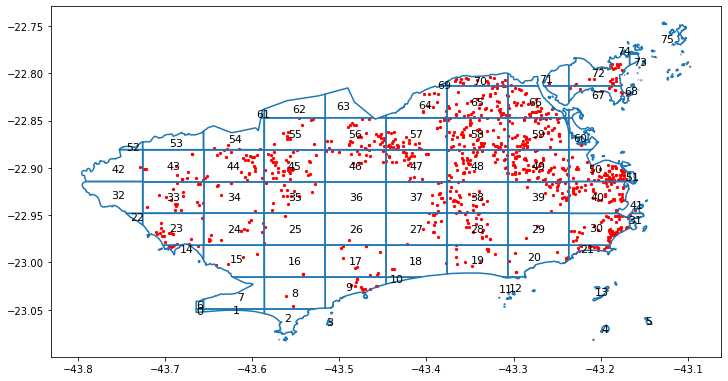

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
app.geo_discretization.boundary.plot(ax=ax)
app.events_data.sample(1000).dropna(subset=['gdiscr']).plot(markersize=5, color='red', ax=ax)
for _, row in app.geo_discretization.iterrows():
    plt.annotate(
        text=row["id"],
        xy=row['coords'],
        horizontalalignment="center",
        verticalalignment="center",
        color='black', fontsize=11
    )

## Hexagonal

In [18]:
app.add_geo_discretization(
    discr_type='H',
    hex_discr_param=6
)
app.geo_discretization.head()

,id,neighbors,geometry,center_lat,center_lon
0,0,"[1, 28]","MULTIPOLYGON (((-43.56234 -23.07989, -43.56213...",-4.842441e+06,-2.562703e+06
1,1,"[30, 28, 16]","POLYGON ((-43.62131 -22.99960, -43.59211 -22.9...",-4.846418e+06,-2.558701e+06
2,2,"[18, 29, 13, 32]","POLYGON ((-43.25551 -22.99816, -43.29109 -22.9...",-4.810509e+06,-2.553644e+06
3,3,"[8, 10, 30]","MULTIPOLYGON (((-43.69579 -22.98673, -43.69603...",-4.857899e+06,-2.553752e+06
4,4,"[20, 5, 9, 26, 27, 15]","POLYGON ((-43.42701 -22.97216, -43.46258 -22.9...",-4.829578e+06,-2.550751e+06


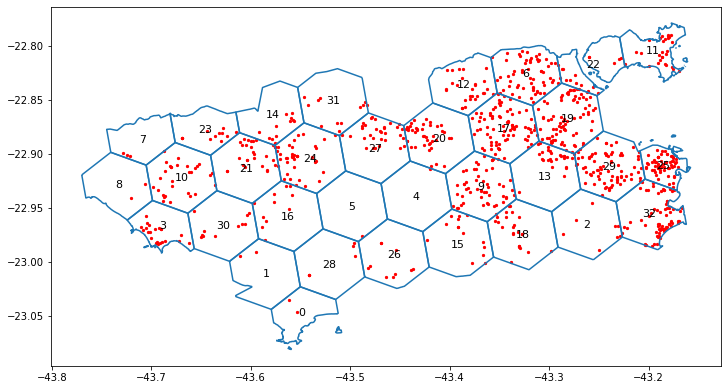

In [20]:
centers = app.geo_discretization.geometry.to_crs("epsg:29193").centroid.to_crs(app.geo_discretization.crs)
coords = centers.apply(lambda x: x.representative_point().coords[:][0])

fig, ax = plt.subplots(figsize=(12, 8))
app.geo_discretization.boundary.plot(ax=ax)
app.events_data.sample(1000).dropna(subset=['gdiscr']).plot(markersize=5, color='red', ax=ax)
for ind, row in app.geo_discretization.iterrows():
    plt.annotate(
        text=row["id"],
        xy=coords.loc[ind],
        horizontalalignment="center",
        verticalalignment="center",
        color='black', fontsize=11
    )


## Custom from graph (doesn't support regressors)

In [21]:
# read nodes data
f = open(r'../Data/street_nodes.txt', "r")
nodes = pd.DataFrame([r.strip().split(" ") for r in f.readlines()], columns=["id", "lat", "lon"])

nodes["id"] = nodes["id"].astype(int)
nodes["lat"] = nodes["lat"].astype(float)
nodes["lon"] = nodes["lon"].astype(float)

# transform to geodataframe
nodes = gpd.GeoDataFrame(
    nodes, 
    geometry=gpd.points_from_xy(nodes.lon, nodes.lat)
).set_crs(app.crs).sample(100)

In [27]:
nodes

,id,lat,lon,geometry
124202,124203,-23.0413,-43.5553,POINT (-43.55530 -23.04130)
248351,248353,-22.8916,-43.5885,POINT (-43.58850 -22.89160)
122932,122933,-22.9622,-43.3986,POINT (-43.39860 -22.96220)
45426,45427,-22.8920,-43.2766,POINT (-43.27660 -22.89200)
44355,44355,-22.9519,-43.2848,POINT (-43.28480 -22.95190)
...,...,...,...,...
262670,262672,-22.9810,-43.6722,POINT (-43.67220 -22.98100)
85707,85708,-22.9284,-43.6284,POINT (-43.62840 -22.92840)
89198,89199,-22.8549,-43.4858,POINT (-43.48580 -22.85490)
77279,77280,-22.8947,-43.5743,POINT (-43.57430 -22.89470)


In [22]:
app.add_geo_discretization('G', custom_data=nodes)
print(app.geo_discretization.count())
app.geo_discretization.head(20)


geometry    100
id          100
dtype: int64


,geometry,id
72692,POINT (-43.33030 -22.97200),0
66594,POINT (-43.57930 -22.88790),1
240728,POINT (-43.32720 -22.85290),2
239224,POINT (-43.31400 -22.84990),3
269388,POINT (-43.62450 -22.95920),4
145452,POINT (-43.29680 -22.90610),5
253979,POINT (-43.23500 -22.92040),6
203797,POINT (-43.58300 -22.99080),7
43441,POINT (-43.17790 -22.90940),8
154249,POINT (-43.55480 -22.99150),9


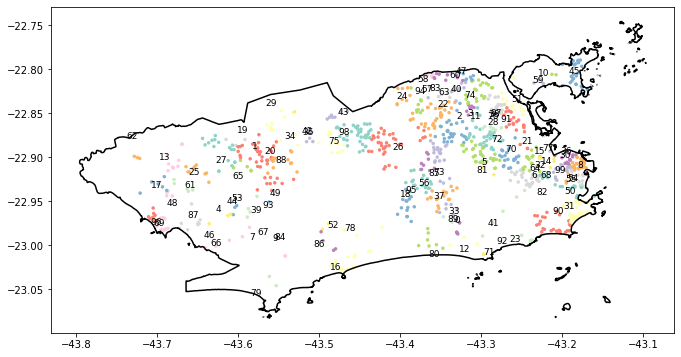

In [23]:
centers = app.geo_discretization.geometry.to_crs("epsg:29193").centroid.to_crs(app.geo_discretization.crs)
coords = centers.apply(lambda x: x.representative_point().coords[:][0])

fig, ax = plt.subplots(figsize=(12, 6))
app.max_borders.boundary.plot(ax=ax, color="black")
app.events_data.dropna(subset=['gdiscr']).plot(markersize=6, column='gdiscr', ax=ax, cmap="Set3")

for ind, row in app.geo_discretization.iterrows():
    plt.annotate(
        text=row["id"],
        xy=coords.loc[ind],
        horizontalalignment="center",
        verticalalignment="center",
        color='black', fontsize=9
    )
plt.show()

## Custom from map

In [25]:
# custom map
custom_map = gpd.read_file(r'../Data/rio_de_janeiro_neighborhoods')
print(type(custom_map))
custom_map = custom_map.set_crs('epsg:29193')
custom_map.head()

<class 'geopandas.geodataframe.GeoDataFrame'>


,Área,NOME,REGIAO_ADM,AREA_PLANE,CODBAIRRO,CODRA,CODBNUM,LINK,area,len,geometry
0,1.705684e+06,Paquetá,PAQUETA,1,13,21,13,Paquetá&area=13,1.705684e+06,24841.426123,"MULTIPOLYGON (((694555.510 7483079.800, 694554..."
1,4.056403e+06,Freguesia,ILHA DO GOVERNADOR,3,98,20,98,Freguesia&area=98,4.056403e+06,18303.596291,"MULTIPOLYGON (((687736.110 7480093.850, 687735..."
2,9.780466e+05,Bancários,ILHA DO GOVERNADOR,3,97,20,97,Bancários&area=97,9.780466e+05,7758.781330,"MULTIPOLYGON (((685934.980 7479388.550, 685937..."
3,1.895742e+07,Galeão,ILHA DO GOVERNADOR,3,104,20,104,Galeão&area=104,1.895742e+07,21510.058418,"MULTIPOLYGON (((681940.940 7479375.300, 681947..."
4,1.672546e+06,Tauá,ILHA DO GOVERNADOR,3,101,20,101,Tauá&area=101,1.672546e+06,8246.109606,"POLYGON ((686812.130 7477581.700, 686796.080 7..."


In [34]:
app.add_geo_discretization('C', custom_data=custom_map)
app.geo_discretization.head()

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3457: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


,geometry,id,neighbors,center_lat,center_lon
0,"MULTIPOLYGON (((-43.10572 -22.74889, -43.10573...",0,[],-4.793761e+06,-2.531271e+06
1,"MULTIPOLYGON (((-43.17175 -22.77662, -43.17175...",1,[2],-4.800155e+06,-2.533544e+06
2,"MULTIPOLYGON (((-43.18920 -22.78319, -43.18918...",2,"[1, 4, 9]",-4.801518e+06,-2.534409e+06
3,"MULTIPOLYGON (((-43.22809 -22.78375, -43.22803...",3,"[5, 14]",-4.807678e+06,-2.536117e+06
4,"POLYGON ((-43.18044 -22.79941, -43.18060 -22.7...",4,"[2, 6, 9, 11]",-4.802147e+06,-2.534993e+06


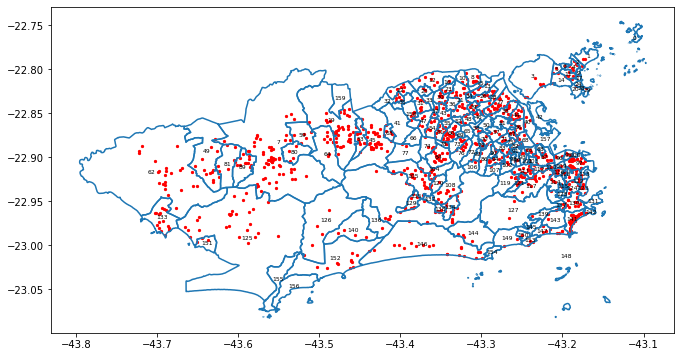

In [35]:
centers = app.geo_discretization.geometry.to_crs("epsg:29193").centroid.to_crs(app.geo_discretization.crs)
coords = centers.apply(lambda x: x.representative_point().coords[:][0])

fig, ax = plt.subplots(figsize=(12, 6))
app.geo_discretization.boundary.plot(ax=ax)
app.events_data.sample(1000).dropna(subset=['gdiscr']).plot(markersize=5, color='red', ax=ax)

for ind, row in app.geo_discretization.iterrows():
    plt.annotate(
        text=row["id"],
        xy=coords.loc[ind],
        horizontalalignment="center",
        verticalalignment="center",
        color='black', fontsize=6
    )

# Add geo located regressors

## Population

In [24]:
app.add_geo_discretization(
    discr_type='H',
    hex_discr_param=7
)

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3457: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [32]:
population = gpd.read_file(r'../Data/regressores/populacao/')
print(population.columns)
population = population[['populacao_','populaca_1','populaca_2','populaca_3','geometry']].copy()
population.head()

Index(['Área', 'bairro', 'REGIAO_ADM', 'AREA_PLANE', 'CODBAIRRO', 'CODRA',
       'CODBNUM', 'LINK', 'area', 'len', '<1', '1', '2', '3', '4', '5 a 9',
       '10 a 14', '15', '16 a 17', '18 a 19', '20 a 24', '25 a 29', '30 a 34',
       '35 a 39', '40 a 44', '45 a 49', '50 a 54', '55 a 59', '60 a 64',
       '65 a 69', '70 a 74', '75 a 79', '>=80', 'populacao_', 'populaca_1',
       'populaca_2', 'populaca_3', 'geometry'],
      dtype='object')


,populacao_,populaca_1,populaca_2,populaca_3,geometry
0,639.0,620.0,1324.0,778.0,"MULTIPOLYGON (((-43.10530 -22.74839, -43.10531..."
1,13692.0,14914.0,31346.0,10559.0,"MULTIPOLYGON (((-43.17133 -22.77613, -43.17133..."
2,2598.0,2903.0,5298.0,1713.0,"MULTIPOLYGON (((-43.18878 -22.78270, -43.18876..."
3,6205.0,5608.0,9468.0,1690.0,"MULTIPOLYGON (((-43.22767 -22.78325, -43.22761..."
4,6700.0,6862.0,12185.0,3820.0,"POLYGON ((-43.18002 -22.79891, -43.18018 -22.7..."


<AxesSubplot:>

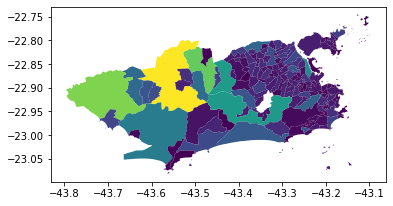

In [33]:
population.plot(column='populacao_')

In [34]:
app.add_geo_variable(population)

<AxesSubplot:>

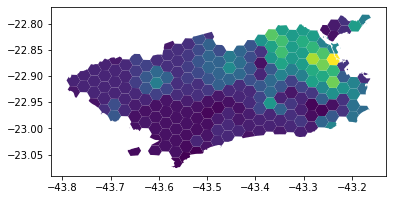

In [35]:
app.geo_discretization.plot(column='populacao_')

# Final Data Structure

In [38]:
app.events_features, app.geo_features, app.time_indexes, app.geo_index

(['prioridade'],
 ['populacao_',
  'populaca_1',
  'populaca_2',
  'populaca_3',
  'populacao_',
  'populaca_1',
  'populaca_2',
  'populaca_3',
  'populacao_',
  'populaca_1',
  'populaca_2',
  'populaca_3'],
 ['dow', 'tdiscr_1', 'tdiscr_2', 'tdiscr_3'],
 'gdiscr')

In [37]:
app.events_data

,prioridade,geometry,ts,dow,tdiscr_1,tdiscr_2,tdiscr_3,gdiscr
182,2,POINT (-43.37277 -22.94098),2016-01-01,0,0,0,1,61.0
61,0,POINT (-43.46271 -23.01302),2016-01-01,0,0,0,1,90.0
1152,1,POINT (-43.57906 -22.87898),2016-01-03,2,0,0,0,164.0
1122,2,POINT (-43.32055 -22.88215),2016-01-03,2,0,0,0,148.0
1581,5,POINT (-43.30509 -22.84370),2016-01-04,3,0,0,0,40.0
...,...,...,...,...,...,...,...,...
285187,3,POINT (-43.24836 -22.91309),2017-12-29,0,0,4,0,193.0
285107,1,POINT (-43.55445 -23.04396),2017-12-29,0,0,4,0,183.0
285036,1,POINT (-43.17910 -22.92469),2017-12-29,0,0,4,0,225.0
285509,1,POINT (-43.26781 -22.86158),2017-12-30,1,0,4,0,22.0
